## Training a high-dimensional neural network to build a predictive model for hedging using real world data
### Machine Learning/Finance/Mathematics
#### Timothy Burt
##### This proof-of-concept generates parameters utilizing nonlinear PDE Black-Scholes-Barenblatt equation which can be used to determine when to buy or sell a derivative stock & its volatility. In addition it could be expanded to use other PDEs and data from other sources.

### Outline

Nonlinear highly dimensional data is becoming increasingly common in today's world. It is becoming increasingly difficult to building predictive models that accurately predict or even describe this highly chaotic data and linear approximations for dimensionality reduction such as principal component analysis (PCA) may destroy useful information. 

For this project I would employ the deep2BSDE (second-order backward stochastic differential equation) algorithm [1] to train a neural network to build a model for derivative securities (swap/option contracts, futures, forwards). 

The nonlinear PDE Black-Scholes-Barenblatt equation from Arbitrage Pricing Theory [2] allows for the modeling of option prices with uncertain volatility and interest rates given appropriate boundary conditions. It may be represented as

$$\frac{1}{2} \sigma^2 (S,t) S^2 \frac{\partial ^2 V}{\partial S^2}+r(S,t)S \frac{\partial V}{\partial S}-r(S,t)V-\frac{\partial V}{\partial t}=0 \label{eq:bsb}$$

where $\sigma$ is the variable volatility, r is the market (risk-free) interest rate, S is the asset price, and t is the time.

The deep2BSDE algorithm utilizes a stochastic gradient descent method to train a neural network to find the parameters for a specific equation by analyzing many example datasets.

The goal of this project would be to deliver a web application or GUI where users can select a particular type of derivative and historical data pulled at runtime from online databases. The ideal case for a future derivative of that type (mean-field approximation) would be displayed along with the Black-Scholes equation parameters, which a user can vary to look at other cases. The best and worst case scenarios would also be displayed to the user based on the maximum and minimum volatilities from the model. 

The power of machine learning can be heavily exploited and a plethora of enlightening visualization schemes utilized with a model such as this. The cross correlation between types of derivative securities or for any other time-dependent y(t) series of data which could be provided by the user could be computed and shown realtime. A causality chain could be generated showing the most heavily dependent securities on other ones to perturbation of the asset price, allowing better estimates on the potential profit/loss it can bring. The deep2BDSE model is high adaptable as it is a nonlinear PDE solver, meaning this project could also be used to model disease proliferation, crop yields, and crime statistics. 

It could also possibly give theoretical insight into the possible "missing physics" from a particular PDE used in those models [3]. It would allow mathematicians to develop better PDEs to model events, and with the enormous number of sensors gathering physical data woldwide correlations between the physics and social sciences could be found which may lead to event/disaster prediction and the better understanding of the connection between physics & life.

In the deep2BDSE model the dimensionality is the number of training sets and the batch size is the total number of timesteps. 

Now let's look at the deep2BDSE model applied to hisotrical NYMEX WTI crude oil futures data, courtesy of Quandl. 

In [4]:
import matplotlib.pyplot as plt
import quandl
import datetime
import numpy as np
import pandas as pd

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (20,5)

Populating the interactive namespace from numpy and matplotlib


In [22]:
def futures_rollover_weights(start_date, expiry_dates, contracts, rollover_days=5):
    """This constructs a pandas DataFrame that contains weights (between 0.0 and 1.0)
    of contract positions to hold in order to carry out a rollover of rollover_days
    prior to the expiration of the earliest contract. The matrix can then be3
    'multiplied' with another DataFrame containing the settle prices of each
    contract in order to produce a continuous time series futures contract.
    https://www.quantstart.com/articles/continuous-futures-contracts-for-backtesting-purposes"""

    # Construct a sequence of dates beginning from the earliest contract start
    # date to the end date of the final contract
    dates = pd.date_range(start_date, expiry_dates[-1], freq='B')

    # Create the 'roll weights' DataFrame that will store the multipliers for
    # each contract (between 0.0 and 1.0)
    roll_weights = pd.DataFrame(np.zeros((len(dates), len(contracts))),
                                index=dates, columns=contracts)
    prev_date = roll_weights.index[0]

    # Loop through each contract and create the specific weightings for
    # each contract depending upon the settlement date and rollover_days
    for i, (item, ex_date) in enumerate(expiry_dates.iteritems()):
        if i < len(expiry_dates) - 1:
            roll_weights.loc[prev_date:ex_date - pd.offsets.BDay(), item] = 1
            roll_rng = pd.date_range(end=ex_date - pd.offsets.BDay(),
                                     periods=rollover_days + 1, freq='B')

            # Create a sequence of roll weights (i.e. [0.0,0.2,...,0.8,1.0]
            # and use these to adjust  the weightings of each future
            decay_weights = np.linspace(0, 1, rollover_days + 1)
            roll_weights.loc[roll_rng, item] = 1 - decay_weights
            roll_weights.loc[roll_rng, expiry_dates.index[i+1]] = decay_weights
        else:
            roll_weights.loc[prev_date:, item] = 1
        prev_date = ex_date
    return roll_weights

In [25]:
# Modified code originally from:
# https://www.quantstart.com/articles/continuous-futures-contracts-for-backtesting-purposes

quandl.ApiConfig.api_key="UeuJWGqy_Gq-C6fwr-uT"
lett = ['F','G','H','J','K','M','N','Q','U','V','X','Z']
yrs = [str(i) for i in range(2009,2019)]
wti_near_s = "CME/CL%s%s" % (lett[0],yrs[0])
wti_start = wti_near_s
dim = 100
bins = 100
wti_all = []
wti_int = []
iterator = 0
for i in range(len(yrs)):
    for j in range(len(lett)):
        if iterator > dim-1:
            break
        else:
            if (iterator%12 == 11):
                yrs_cur = yrs[i+1]
                mon = 12
            else:
                yrs_cur = yrs[i]
                mon = 11
            wti_far_s = "CME/CL%s%s" % (lett[(iterator+1)%12],yrs_cur)
            if ((iterator + 1)%10) == 0:    
                print('Iteration %d out of %d, %s - %s' % (iterator+1,dim,wti_near_s,wti_far_s))
            dt_start = datetime.datetime(int(yrs_cur),mon, 1)
            dt_end = datetime.datetime(int(yrs_cur),mon, 1)
            wti_near = quandl.get(wti_near_s)
            wti_far = quandl.get(wti_far_s)
            # Make sure to adjust the contracts to reflect your current near/far contracts
            wti = pd.DataFrame({wti_near_s[4:]: wti_near['Settle'],
                                wti_far_s[4:]: wti_far['Settle']}, index=wti_far.index)
            
            int_str = ['Open Interest','Prev. Day Open Interest']

            wti_near_int = pd.DataFrame(wti_near[wti_near.iloc[:,-1] != 0], index=wti_near.index)
            wti_far_int = pd.DataFrame(wti_far[wti_far.iloc[:,-1] != 0], index=wti_far.index)
            
            # Create the dictionary of expiry dates for each contract
            expiry_dates = pd.Series({wti_near_s[4:]: dt_start,
                                     wti_far_s[4:]: dt_end}).sort_values()
        
            # Obtain the rollover weighting matrix/DataFrame
            weights = futures_rollover_weights(wti_near.index[0], expiry_dates, wti.columns)
            
            wti_cts = (wti * weights).sum(1).dropna()
            wti_near_int = wti_near_int.iloc[:,-1].dropna()
            wti_far_int = wti_far_int.iloc[:,-1].dropna()
            r_near = (wti_near_int.iloc[-1].astype(float) / wti_near_int.astype(float))**(1.0/9.0) - 1.0
            r_far = (wti_far_int.iloc[-1].astype(float) / wti_far_int.astype(float))**(1.0/9.0) - 1.0
            r_avg = (r_near+r_far) / 2.0
            wti_cts = list(wti_cts.tail(bins))
            r_avg = list(r_avg.tail(bins))
            #print(len(wti_cts))  # DEBUG
            #print(wti_int)  # DEBUG
            wti_all.append(wti_cts)
            wti_int.append(r_avg)
            wti_near_s = "CME/CL%s%s" % (lett[(iterator+1)%12],yrs_cur)
            
            iterator += 1

# Output the merged series of contract settle prices
wti_end = wti_near_s
fn = 'fdata'
wti_all = np.asarray(wti_all)
wti_int_all = np.asarray(wti_int)
# normalize to R^d from (-1,1)
allones = np.ones((dim,bins))
wti_all_avg = np.mean(wti_all) * allones
wti_all_std = np.std(wti_all) * allones
wti_all_norm = np.zeros((dim,bins))
wti_all_znorm = (wti_all - wti_all_avg)/wti_all_std
wti_all_max = np.max(np.max(wti_all_znorm))
wti_all_min = np.min(np.min(wti_all_znorm))
for i in range(dim):
    for j in range(bins):
        if wti_all_znorm[i,j] >= 0:
            wti_all_norm[i,j] = wti_all_znorm[i,j]/wti_all_max
        else:
            wti_all_norm[i,j] = (wti_all_znorm[i,j]/wti_all_min)+wti_all_min
np.save(fn+'.npy',np.reshape(wti_all_norm,(bins,dim)))
np.save(fn+'_int.npy',wti_int_all)

print('Data export complete to %s! Data shape %s dimensions, %s bins. Start future: %s - End future: %s' 
      % (fn, wti_all_norm.shape[0], wti_all_norm.shape[1], wti_start, wti_end))

Iteration 10 out of 100, CME/CLV2009 - CME/CLX2009
Iteration 20 out of 100, CME/CLQ2010 - CME/CLU2010
Iteration 30 out of 100, CME/CLM2011 - CME/CLN2011
Iteration 40 out of 100, CME/CLJ2012 - CME/CLK2012
Iteration 50 out of 100, CME/CLG2013 - CME/CLH2013
Iteration 60 out of 100, CME/CLZ2013 - CME/CLF2014
Iteration 70 out of 100, CME/CLV2014 - CME/CLX2014
Iteration 80 out of 100, CME/CLQ2015 - CME/CLU2015
Iteration 90 out of 100, CME/CLM2016 - CME/CLN2016
Iteration 100 out of 100, CME/CLJ2017 - CME/CLK2017
Data export complete to fdata! Data shape 100 dimensions, 100 bins. Start future: CME/CLF2009 - End future: CME/CLK2017


I will next apply derived formulas to compute upper and lower bounds for the volatility, which deep2BDSE will require.

/usr/local/lib/python3.6/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Model 10 has volatility bds 0.000 to 0.206
Model 20 has volatility bds 0.000 to 0.226
Model 30 has volatility bds 0.000 to 0.238
Model 40 has volatility bds 0.000 to 0.229
Model 50 has volatility bds 0.000 to 0.226
Model 60 has volatility bds 0.000 to 0.306
Model 70 has volatility bds 0.000 to 0.236
Model 80 has volatility bds 0.000 to 0.284
Model 90 has volatility bds 0.000 to 0.267
Model 100 has volatility bds 0.000 to 0.265


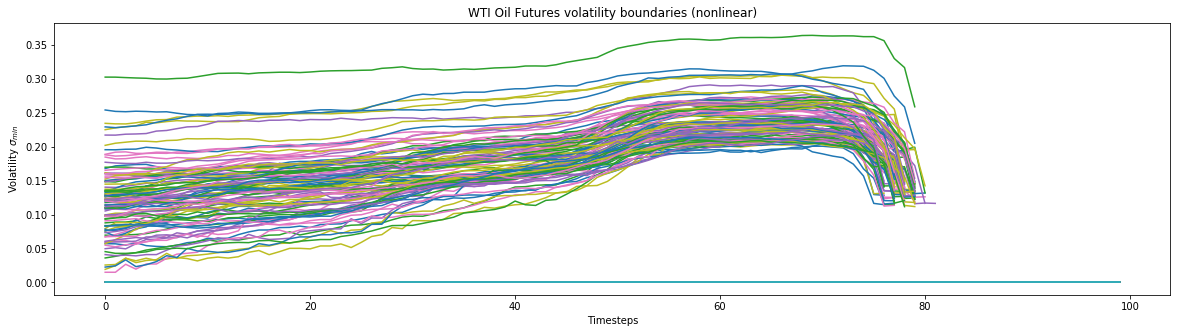

In [18]:
import scipy.optimize as sp
dim=100
wti_all_norm = np.load('fdata.npy')
r_est = np.load('fdata_int.npy')

# generate true solution to PDE
def test_fxn(t,rpg,c):
    return c*np.exp((rpg**2)*(dim-t))  # rpg - sigma(sigma+r/sigma)

sigma_max = np.zeros((dim,dim))
sigma_min = np.zeros((dim,dim))
sigma_sup = np.zeros(dim)
sigma_inf = np.zeros(dim)

for i in range(dim):
    r_p_sigmam = r_est[i]
    x = np.arange(len(wti_all_norm[i]))
    u_popt = sp.curve_fit(test_fxn, x, wti_all_norm[i], p0=(0.5,1))
    #plt.plot(x,test_fxn(x,r_p_sigmam, wti_all_norm[i]))

    for j in x:
        if j >= 0:
            sigma_max[i][j] = u_popt[0][0] - r_est[i][j]  # variable volatility in t
        else:
            sigma_min[i][j] = u_popt[0][0] - r_est[i][j]
    
    
    sigma_sup[i] = np.max(np.max(np.nan_to_num(sigma_max[i]),0))
    sigma_inf[i] = np.min(np.min(np.nan_to_num(sigma_min[i]),0))


    plt.plot(x,sigma_max[i])
    plt.ylabel('Volatility $\sigma_{max}$')
  
    plt.plot(x, sigma_min[i])
    plt.ylabel('Volatility $\sigma_{min}$')
    
    if ((i + 1)%10) == 0:  
        print('Model %d has volatility bds %.3f to %.3f' % (i+1,sigma_inf[i],sigma_sup[i]))

plt.xlabel('Timesteps')
plt.title('WTI Oil Futures volatility boundaries (nonlinear)')
plt.savefig('vol_lims.pdf')
    


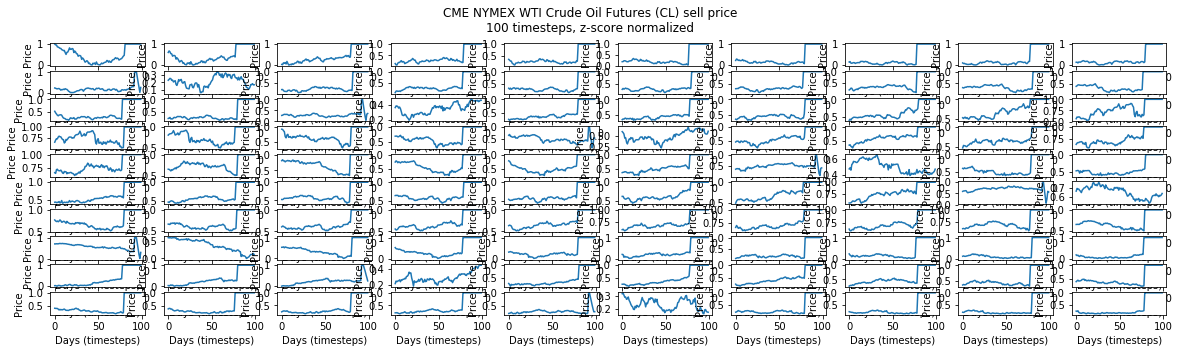

In [52]:
wti_cts = np.load('fdata.npy')
dim = 100
pdim = int(dim / np.sqrt(dim))
fig, axes = plt.subplots(pdim,pdim)
j = 0
for i in range(dim):
    #print("%d of %d" % (i, len(wti_cts)))
    x = np.arange(0,len(wti_cts[i]))  
    if ((i%pdim == 0) and (i != 0)):
        j += 1
    axes[j,i%pdim].plot(x,wti_cts[i])
    axes[j,i%pdim].set_xlabel("Days (timesteps)")
    axes[j,i%pdim].set_ylabel("Price")
fig.suptitle("CME NYMEX WTI Crude Oil Futures (CL) sell price\n100 timesteps, z-score normalized")
plt.savefig('data.pdf',dpi=1000)
plt.show()

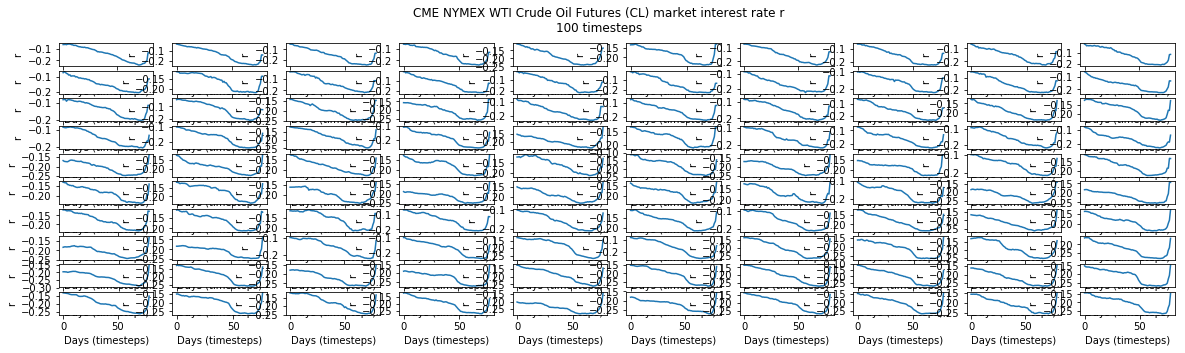

In [8]:
wti_cts = np.load('fdata_int.npy')
pdim = int(dim / np.sqrt(dim))
fig, axes = plt.subplots(pdim,pdim)
j = 0
for i in range(dim):
    #print("%d of %d" % (i, len(wti_cts)))
    x = np.arange(0,len(wti_cts))  
    if ((i%pdim == 0) and (i != 0)):
        j += 1
    axes[j,i%pdim].plot(x,wti_cts[i])
    axes[j,i%pdim].set_xlabel("Days (timesteps)")
    axes[j,i%pdim].set_ylabel("r")
fig.suptitle("CME NYMEX WTI Crude Oil Futures (CL) market interest rate r\n100 timesteps")
plt.savefig('data_int.pdf',dpi=1000)
plt.show()

Now we may apply the deep2BSDE algorithm to train the neural network to find optimal parameters for the BSB equation.

In [1]:
import deep2BSDE_BSB as bsb
import numpy as np

wti_cts = np.load('fdata.npy')
bsb.train_nn(wti_cts[1])

step:  0  loss:  7454.427272342305  Y0:  [ 0.60061503  0.67392777  0.62701475  0.54210754  0.53265359  0.42134666
  0.4536328   0.45613007  0.43115737  0.28132111  0.34607178  0.29898038
  0.22638115  0.1448631   0.17661411  0.21514343  0.18036002  0.08243132
  0.10151761  0.03641019  0.02160494  0.01250774  0.09848521  0.07583139
  0.11061481  0.04069122  0.15948997  0.0681612  -1.76421447 -1.77135519
  0.02089143 -1.7445378  -1.69423535 -1.72676532 -1.70137608 -1.66773532
 -1.65662753 -1.64663051 -1.57458852 -1.58331607 -1.65726226 -1.59997777
 -1.65853172 -1.66043591 -1.57887295 -1.54316932 -1.54142381 -1.49207346
 -1.45589378 -1.51032198 -1.48334591 -1.50492677 -1.58141188 -1.55411844
 -1.52793577 -1.5157172  -1.48255249 -1.43589975 -1.44684886 -1.40797157
 -1.39321407 -1.33561222 -1.37306136 -1.40971709 -1.39400749 -1.48239381
 -1.51000462 -1.54919927 -1.54554956 -1.4511333  -1.4363758  -1.42257039
 -1.37115716 -1.37417214 -1.366238   -1.33640563 -1.35401942 -1.38940569
 -0.774668

ValueError: setting an array element with a sequence.

In [10]:
err = np.loadtxt('BSB.csv',delimiter=',')

plt.plot[err[0],err[1]]


TypeError: 'function' object is not subscriptable

##### References:

[1] Christian Beck, Weinan E: “Machine learning approximation algorithms for high-dimensional fully nonlinear partial differential equations and second-order backward stochastic differential equations”, arxiV, 2017.

[2] M. Avellaneda, A. Levy ∗, and A. ParÁS, “Pricing and hedging derivative securities in markets with uncertain volatilities,” Applied Mathematical Finance, vol. 2, no. 2, pp. 73–88, Jun. 1995.

[3] M. Raissi and G. E. Karniadakis, “Hidden physics models: Machine learning of nonlinear partial differential equations,” Journal of Computational Physics, vol. 357, pp. 125–141, Mar. 2018.

In [19]:
print(r_avg

NameError: name 'r_avg' is not defined